# **BMI Predictor for Life Insurance Underwriting**

In [ ]:
!pip install pycaret

#Visualization libraries
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import numpy as np


#Feature engineering and metric
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import matplotlib.ticker as mtick
from pycaret.regression import *
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import HuberRegressor, LinearRegression



In [214]:
data = pd.read_csv("./Dummy-Data.csv")
data.shape

(100, 6)

In [215]:
data.head(10)

,AppID,Ins_Age,Ins_Gender,Ht,Wt,IssueDate
0,56372,31,Male,510,185,NaN
1,34565,35,Male,510,205,NaN
2,57732,45,Female,510,125,NaN
3,87324,38,Male,503,175,NaN
4,12323,39,Female,600,252,NaN
5,75323,35,Male,507,180,NaN
6,23466,35,Male,509,225,NaN
7,24545,35,Female,507,210,NaN
8,63462,40,Female,600,155,NaN
9,87432,48,Male,507,170,NaN


# Preprocessing

In [216]:
columns = list(data.columns)
Numerical_variables = []
Categorical_variables = []

#Numerical_variables = [column for column in columns if type(column)=='int64' or 'float64']
Numerical_variables = list(data.select_dtypes(include=[np.float64,np.int64]).columns)
Categorical_variables = list(data.select_dtypes(include=[object]).columns)

print("Number of Numerical columns : ", len(Numerical_variables))
print()
print("Numerical_variables : \n\n ", Numerical_variables)

print()

print("Number of Categorical columns : ", len(Categorical_variables))
print()
print("Categorical_variables : \n\n ", Categorical_variables)

Number of Numerical columns :  5

Numerical_variables : 

  ['AppID', 'Ins_Age', 'Ht', 'Wt', 'IssueDate']

Number of Categorical columns :  1

Categorical_variables : 

  ['Ins_Gender']


Lets check missing value count. 

Text(0.5, 1.0, 'Percentage of missing values per feature')

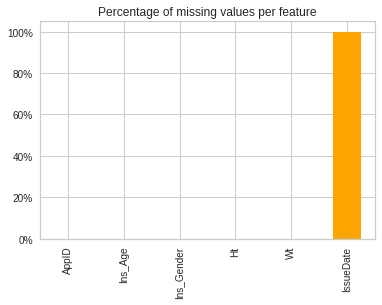

In [217]:
new_data = data.copy()
new_data.isna().sum()

ax = (new_data.isnull().mean() * 100).plot(kind='bar', color ='orange')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Percentage of missing values per feature')



Nulls are present in our data, lets explore it. 

In [218]:
df_pivot = pd.DataFrame({'types': new_data.dtypes,
                         'nulls': new_data.isna().sum(),
                          '% nulls': new_data.isna().sum() / data.shape[0],
                          'size': new_data.shape[0],
                          'uniques': new_data.nunique()})
df_pivot

,types,nulls,% nulls,size,uniques
AppID,int64,0,0.0,100,76
Ins_Age,int64,0,0.0,100,32
Ins_Gender,object,0,0.0,100,2
Ht,int64,0,0.0,100,16
Wt,int64,0,0.0,100,27
IssueDate,float64,100,1.0,100,0


**IssueDate feature is not relevant to us as its 100% Null, also AppID is not relevant.**



In [219]:
data.drop(['AppID','IssueDate'],1,inplace=True)


Ht And Wt features are in Feet inches and Pounds. Lets convert it into Centimetre and Kg.

In [220]:
def transform_height(height):
  height_feet = int(height[0])
  height_inch = int(height[1:])  
  height_inch += int(height_feet) * 12
  h_cm = round(height_inch * 2.54, 1)
  #print(h_cm)

  return h_cm

def transform_weight(wt_in_pounds):
  wt_in_kg = wt_in_pounds * 0.453592
  return wt_in_kg

    

In [221]:
data['Height_in_cm'] =  data['Ht'].apply(lambda x: transform_height(str(x)) )
data['Weight_in_kg'] =  data['Wt'].apply(lambda x: transform_weight(x) )
data.drop(columns=['Ht'],inplace=True)
data.drop(columns=['Wt'],inplace=True)


# **Objectives**

## 1. Create the training dataset based on the BMI business rules.

**Lets Calculate BMI by formula [weight (kg) / height (cm) / height (cm)] x 10,000**


In [222]:
data['BMI'] = data['Weight_in_kg']/data['Height_in_cm']/data['Height_in_cm']
data['BMI'] = data['BMI'] * 10000

In [223]:
data.rename(columns = {'Ins_Age' : 'Age','Ins_Gender' : 'Gender'},inplace = True)


In [224]:
data

,Age,Gender,Height_in_cm,Weight_in_kg,BMI
0,31,Male,177.8,83.914520,26.544442
1,35,Male,177.8,92.986360,29.414111
2,45,Female,177.8,56.699000,17.935434
3,38,Male,160.0,79.378600,31.007266
4,39,Female,182.9,114.305184,34.169492
...,...,...,...,...,...
95,35,Male,177.8,124.737800,39.457954
96,27,Male,193.0,65.770840,17.657075
97,35,Female,170.2,86.182480,29.750884
98,38,Female,177.8,65.317248,20.661620


**Lets Calculate Price_Quotation based on Business Rules.**

In [226]:
#For Male
data.loc[ ( ((data['Age'] >= 18 ) & (data['Age'] <= 39 ))  & ((data['BMI'] < 17.49 ) | (data['BMI'] > 38.5 )) ), ['Price_Quote_USD','Reason'] ] = "750 USD","Age is between 18 to 39 and BMI is either less than 17.49 or greater than 38.5."
data.loc[( ((data['Age'] >= 40 ) & (data['Age'] <= 59 ))  & ((data['BMI'] < 18.49 ) | (data['BMI'] > 38.5 )) ), ['Price_Quote_USD','Reason'] ] = "1000 USD","Age is between 40 to 59 and BMI is either less than 18.49 or greater then 38.5."
data.loc[( (data['Age'] > 60 )   & ((data['BMI'] < 18.49 ) | (data['BMI'] > 45.5 )) ), ['Price_Quote_USD','Reason'] ] = "2000 USD","Age is greater than 60 and BMI is either less than 18.49 or greater than 38.5."


#For Female
data.loc[  (data['Gender']=="Female") & ( ((data['Age'] >= 18 ) & (data['Age'] <= 39 ))  & ((data['BMI'] < 17.49 ) | (data['BMI'] > 38.5 )) ), ['Price_Quote_USD','Reason'] ] = "675 USD","Age is between 18 to 39 and BMI is either less than 17.49 or greater than 38.5."
data.loc[ (data['Gender']=="Female") & ( ((data['Age'] >= 40 ) & (data['Age'] <= 59 ))  & ((data['BMI'] < 18.49 ) | (data['BMI'] > 38.5 )) ), ['Price_Quote_USD','Reason'] ] = "900 USD","Age is between 40 to 59 and BMI is either less than 18.49 or greater then 38.5."
data.loc[ (data['Gender']=="Female") &  ( (data['Age'] > 60 )   & ((data['BMI'] < 18.49 ) | (data['BMI'] > 45.5 )) ), ['Price_Quote_USD','Reason'] ] = "1800 USD","Age is greater than 60 and BMI is either less than 18.49 or greater than 38.5."

#Other case for Male and Female
data.loc[ (data['Gender']=="Female") & (data['Price_Quote_USD'].isna() ), ['Price_Quote_USD','Reason'] ] = "450 USD","BMI is in right range."
data.loc[ (data['Price_Quote_USD'].isna() ), ['Price_Quote_USD','Reason'] ] = "500 USD","BMI is in right range."



In [227]:
data

,Age,Gender,Height_in_cm,Weight_in_kg,BMI,Price_Quote_USD,Reason
0,31,Male,177.8,83.914520,26.544442,500 USD,BMI is in right range.
1,35,Male,177.8,92.986360,29.414111,500 USD,BMI is in right range.
2,45,Female,177.8,56.699000,17.935434,900 USD,Age is between 40 to 59 and BMI is either less...
3,38,Male,160.0,79.378600,31.007266,500 USD,BMI is in right range.
4,39,Female,182.9,114.305184,34.169492,450 USD,BMI is in right range.
...,...,...,...,...,...,...,...
95,35,Male,177.8,124.737800,39.457954,750 USD,Age is between 18 to 39 and BMI is either less...
96,27,Male,193.0,65.770840,17.657075,500 USD,BMI is in right range.
97,35,Female,170.2,86.182480,29.750884,450 USD,BMI is in right range.
98,38,Female,177.8,65.317248,20.661620,450 USD,BMI is in right range.


# 2. Build model to predict BMI

In [230]:
data = pd.read_csv("./Dummy-Data.csv")
data.shape

(100, 6)

In [231]:
data.head(10)

,AppID,Ins_Age,Ins_Gender,Ht,Wt,IssueDate
0,56372,31,Male,510,185,NaN
1,34565,35,Male,510,205,NaN
2,57732,45,Female,510,125,NaN
3,87324,38,Male,503,175,NaN
4,12323,39,Female,600,252,NaN
5,75323,35,Male,507,180,NaN
6,23466,35,Male,509,225,NaN
7,24545,35,Female,507,210,NaN
8,63462,40,Female,600,155,NaN
9,87432,48,Male,507,170,NaN


# Preprocessing

In [232]:
columns = list(data.columns)
Numerical_variables = []
Categorical_variables = []

#Numerical_variables = [column for column in columns if type(column)=='int64' or 'float64']
Numerical_variables = list(data.select_dtypes(include=[np.float64,np.int64]).columns)
Categorical_variables = list(data.select_dtypes(include=[object]).columns)

print("Number of Numerical columns : ", len(Numerical_variables))
print()
print("Numerical_variables : \n\n ", Numerical_variables)

print()

print("Number of Categorical columns : ", len(Categorical_variables))
print()
print("Categorical_variables : \n\n ", Categorical_variables)

Number of Numerical columns :  5

Numerical_variables : 

  ['AppID', 'Ins_Age', 'Ht', 'Wt', 'IssueDate']

Number of Categorical columns :  1

Categorical_variables : 

  ['Ins_Gender']


Lets check missing value count. 

Text(0.5, 1.0, 'Percentage of missing values per feature')

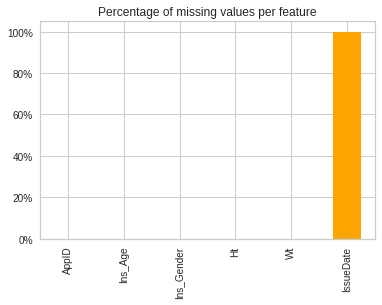

In [233]:
new_data = data.copy()
new_data.isna().sum()

ax = (new_data.isnull().mean() * 100).plot(kind='bar', color ='orange')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Percentage of missing values per feature')



Nulls are present in our data, lets explore it. 

In [234]:
df_pivot = pd.DataFrame({'types': new_data.dtypes,
                         'nulls': new_data.isna().sum(),
                          '% nulls': new_data.isna().sum() / data.shape[0],
                          'size': new_data.shape[0],
                          'uniques': new_data.nunique()})
df_pivot

,types,nulls,% nulls,size,uniques
AppID,int64,0,0.0,100,76
Ins_Age,int64,0,0.0,100,32
Ins_Gender,object,0,0.0,100,2
Ht,int64,0,0.0,100,16
Wt,int64,0,0.0,100,27
IssueDate,float64,100,1.0,100,0


IssueDate feature is not relevant to us as its 100% Null, also AppID is not relevant.



In [235]:
data.drop(['AppID','IssueDate'],1,inplace=True)


In [236]:
data

,Ins_Age,Ins_Gender,Ht,Wt
0,31,Male,510,185
1,35,Male,510,205
2,45,Female,510,125
3,38,Male,503,175
4,39,Female,600,252
...,...,...,...,...
95,35,Male,510,275
96,27,Male,604,145
97,35,Female,507,190
98,38,Female,510,144


Ht And Wt features are in Feet inches and Pounds. Lets convert it into Centimetre and Kg.

In [237]:
def transform_height(height):
  height_feet = int(height[0])
  height_inch = int(height[1:])  
  height_inch += int(height_feet) * 12
  h_cm = round(height_inch * 2.54, 1)
  #print(h_cm)

  return h_cm

def transform_weight(wt_in_pounds):
  wt_in_kg = wt_in_pounds * 0.453592
  return wt_in_kg


    

In [238]:
data['Height_in_cm'] =  data['Ht'].apply(lambda x: transform_height(str(x)) )
data['Weight_in_kg'] =  data['Wt'].apply(lambda x: transform_weight(x) )
data.drop(columns=['Ht'],inplace=True)
data.drop(columns=['Wt'],inplace=True)


Lets Calculate BMI by formula [weight (kg) / height (cm) / height (cm)] x 10,000


In [239]:
data['BMI'] = data['Weight_in_kg']/data['Height_in_cm']/data['Height_in_cm']
data['BMI'] = data['BMI'] * 10000

In [240]:
data.rename(columns = {'Ins_Age' : 'Age','Ins_Gender' : 'Gender'},inplace = True)


In [241]:
data

,Age,Gender,Height_in_cm,Weight_in_kg,BMI
0,31,Male,177.8,83.914520,26.544442
1,35,Male,177.8,92.986360,29.414111
2,45,Female,177.8,56.699000,17.935434
3,38,Male,160.0,79.378600,31.007266
4,39,Female,182.9,114.305184,34.169492
...,...,...,...,...,...
95,35,Male,177.8,124.737800,39.457954
96,27,Male,193.0,65.770840,17.657075
97,35,Female,170.2,86.182480,29.750884
98,38,Female,177.8,65.317248,20.661620


Transform Categorical and Numerical columns 

In [242]:
Numerical_variables = list(data.select_dtypes(include=[np.float64,np.int64]).columns)
Categorical_variables = list(data.select_dtypes(include=[object]).columns)

In [243]:
sc = StandardScaler()
data[Numerical_variables] = sc.fit_transform(data[Numerical_variables])

data[Categorical_variables] = pd.get_dummies(data[Categorical_variables],drop_first=True)



In [244]:
data

,Age,Gender,Height_in_cm,Weight_in_kg,BMI
0,-0.524779,1,0.418265,0.721200,0.297628
1,-0.192641,1,0.418265,1.447849,0.882603
2,0.637707,0,0.418265,-1.458749,-1.457297
3,0.056464,1,-1.367136,0.357875,1.207363
4,0.139498,0,0.929813,3.155476,1.851975
...,...,...,...,...,...
95,-0.192641,1,0.418265,3.991123,2.930015
96,-0.856918,1,1.942877,-0.732100,-1.514039
97,-0.192641,0,-0.344041,0.902862,0.951253
98,0.056464,0,0.418265,-0.768432,-0.901571


**Finding the best model**

In [38]:
experiment = setup(data,target="BMI")


,Description,Value
0,session_id,1784
1,Target,BMI
2,Original Data,"(100, 5)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(69, 4)"


In [39]:
compare_models()


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.0755,0.0114,0.1011,0.9830,0.0484,0.9817,0.024
lr,Linear Regression,0.0754,0.0114,0.1011,0.9829,0.0484,0.9833,0.607
lar,Least Angle Regression,0.0754,0.0114,0.1011,0.9829,0.0484,0.9833,0.025
ridge,Ridge Regression,0.0768,0.0117,0.1025,0.9827,0.0497,0.9435,0.023
huber,Huber Regressor,0.0740,0.0119,0.1023,0.9827,0.0465,0.5798,0.034
par,Passive Aggressive Regressor,0.0909,0.0144,0.1165,0.9775,0.0592,1.5182,0.025
et,Extra Trees Regressor,0.1232,0.0702,0.2001,0.9347,0.0847,0.3207,0.443
gbr,Gradient Boosting Regressor,0.1848,0.1059,0.2626,0.8921,0.1332,1.3524,0.062
rf,Random Forest Regressor,0.2232,0.1494,0.3319,0.8348,0.1611,0.7794,0.495
knn,K Neighbors Regressor,0.3011,0.1824,0.3846,0.7916,0.1882,1.0665,0.080


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

**Bayesian regressor has the lowest MSE, performs the best**

In [40]:
X = data.iloc[:,:-1]
y = data['BMI']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


In [44]:
reg = BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [46]:
reg.fit(X_train, y_train)


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [48]:
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

**After Fitting getting Train set MSE: 0.0097, Test set MSE: 0.0092**

In [51]:
print("Train set MSE: {:.4f}".format(mean_squared_error(y_train, y_pred_train)))
print("Test set MSE: {:.4f}".format(mean_squared_error(y_test, y_pred_test)))

Train set MSE: 0.0097
Test set MSE: 0.0092


# 3. Build model to predict BMI based on the BMI business rules


**Will add additional features such as Price Quotation according to the business rules. It will help to further improve our model**

In [148]:
data = pd.read_csv("./Dummy-Data.csv")
data.shape

(100, 6)

In [149]:
data.head(10)

,AppID,Ins_Age,Ins_Gender,Ht,Wt,IssueDate
0,56372,31,Male,510,185,NaN
1,34565,35,Male,510,205,NaN
2,57732,45,Female,510,125,NaN
3,87324,38,Male,503,175,NaN
4,12323,39,Female,600,252,NaN
5,75323,35,Male,507,180,NaN
6,23466,35,Male,509,225,NaN
7,24545,35,Female,507,210,NaN
8,63462,40,Female,600,155,NaN
9,87432,48,Male,507,170,NaN


# Preprocessing

In [150]:
columns = list(data.columns)
Numerical_variables = []
Categorical_variables = []

#Numerical_variables = [column for column in columns if type(column)=='int64' or 'float64']
Numerical_variables = list(data.select_dtypes(include=[np.float64,np.int64]).columns)
Categorical_variables = list(data.select_dtypes(include=[object]).columns)

print("Number of Numerical columns : ", len(Numerical_variables))
print()
print("Numerical_variables : \n\n ", Numerical_variables)

print()

print("Number of Categorical columns : ", len(Categorical_variables))
print()
print("Categorical_variables : \n\n ", Categorical_variables)

Number of Numerical columns :  5

Numerical_variables : 

  ['AppID', 'Ins_Age', 'Ht', 'Wt', 'IssueDate']

Number of Categorical columns :  1

Categorical_variables : 

  ['Ins_Gender']


Lets check missing value count. 

Text(0.5, 1.0, 'Percentage of missing values per feature')

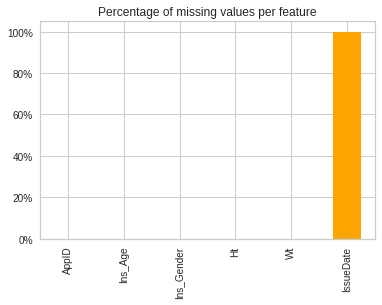

In [151]:
new_data = data.copy()
new_data.isna().sum()

ax = (new_data.isnull().mean() * 100).plot(kind='bar', color ='orange')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Percentage of missing values per feature')



Nulls are present in our data, lets explore it. 

In [152]:
df_pivot = pd.DataFrame({'types': new_data.dtypes,
                         'nulls': new_data.isna().sum(),
                          '% nulls': new_data.isna().sum() / data.shape[0],
                          'size': new_data.shape[0],
                          'uniques': new_data.nunique()})
df_pivot

,types,nulls,% nulls,size,uniques
AppID,int64,0,0.0,100,76
Ins_Age,int64,0,0.0,100,32
Ins_Gender,object,0,0.0,100,2
Ht,int64,0,0.0,100,16
Wt,int64,0,0.0,100,27
IssueDate,float64,100,1.0,100,0


IssueDate feature is not relevant to us as its 100% Null, also AppID is not relevant.



In [153]:
data.drop(['AppID','IssueDate'],1,inplace=True)


In [154]:
data

,Ins_Age,Ins_Gender,Ht,Wt
0,31,Male,510,185
1,35,Male,510,205
2,45,Female,510,125
3,38,Male,503,175
4,39,Female,600,252
...,...,...,...,...
95,35,Male,510,275
96,27,Male,604,145
97,35,Female,507,190
98,38,Female,510,144


Ht And Wt features are in Feet inches and Pounds. Lets convert it into Centimetre and Kg.

In [155]:
def transform_height(height):
  height_feet = int(height[0])
  height_inch = int(height[1:])  
  height_inch += int(height_feet) * 12
  h_cm = round(height_inch * 2.54, 1)
  #print(h_cm)

  return h_cm

def transform_weight(wt_in_pounds):
  wt_in_kg = wt_in_pounds * 0.453592
  return wt_in_kg

    

In [156]:
data['Height'] =  data['Ht'].apply(lambda x: transform_height(str(x)) )
data['Weight'] =  data['Wt'].apply(lambda x: transform_weight(x) )
data.drop(columns=['Ht'],inplace=True)
data.drop(columns=['Wt'],inplace=True)


Lets Calculate BMI by formula [weight (kg) / height (cm) / height (cm)] x 10,000


In [157]:
data['BMI'] = data['Weight']/data['Height']/data['Height']
data['BMI'] = data['BMI'] * 10000

In [158]:
data.rename(columns = {'Ins_Age' : 'Age','Ins_Gender' : 'Gender'},inplace = True)


In [159]:
data

,Age,Gender,Height,Weight,BMI
0,31,Male,177.8,83.914520,26.544442
1,35,Male,177.8,92.986360,29.414111
2,45,Female,177.8,56.699000,17.935434
3,38,Male,160.0,79.378600,31.007266
4,39,Female,182.9,114.305184,34.169492
...,...,...,...,...,...
95,35,Male,177.8,124.737800,39.457954
96,27,Male,193.0,65.770840,17.657075
97,35,Female,170.2,86.182480,29.750884
98,38,Female,177.8,65.317248,20.661620


Lets Calculate Price_Quotation based on Business Rules.

In [160]:
data.loc[ ( ((data['Age'] >= 18 ) & (data['Age'] <= 39 ))  & ((data['BMI'] < 17.49 ) | (data['BMI'] > 38.5 )) ), ['Price_Quote','Reason'] ] = "750 USD","Age is between 18 to 39 and BMI is either less than 17.49 or greater than 38.5."
data.loc[( ((data['Age'] >= 40 ) & (data['Age'] <= 59 ))  & ((data['BMI'] < 18.49 ) | (data['BMI'] > 38.5 )) ), ['Price_Quote','Reason'] ] = "1000 USD","Age is between 40 to 59 and BMI is either less than 18.49 or greater then 38.5."
data.loc[( (data['Age'] > 60 )   & ((data['BMI'] < 18.49 ) | (data['BMI'] > 45.5 )) ), ['Price_Quote','Reason'] ] = "2000 USD","Age is greater than 60 and BMI is either less than 18.49 or greater than 38.5."



data.loc[  (data['Gender']=="Female") & ( ((data['Age'] >= 18 ) & (data['Age'] <= 39 ))  & ((data['BMI'] < 17.49 ) | (data['BMI'] > 38.5 )) ), ['Price_Quote','Reason'] ] = "675 USD","Age is between 18 to 39 and BMI is either less than 17.49 or greater than 38.5."
data.loc[ (data['Gender']=="Female") & ( ((data['Age'] >= 40 ) & (data['Age'] <= 59 ))  & ((data['BMI'] < 18.49 ) | (data['BMI'] > 38.5 )) ), ['Price_Quote','Reason'] ] = "900 USD","Age is between 40 to 59 and BMI is either less than 18.49 or greater then 38.5."
data.loc[ (data['Gender']=="Female") &  ( (data['Age'] > 60 )   & ((data['BMI'] < 18.49 ) | (data['BMI'] > 45.5 )) ), ['Price_Quote','Reason'] ] = "1800 USD","Age is greater than 60 and BMI is either less than 18.49 or greater than 38.5."

data.loc[ (data['Gender']=="Female") & (data['Price_Quote'].isna() ), ['Price_Quote','Reason'] ] = "450 USD","BMI is in right range."
data.loc[ (data['Price_Quote'].isna() ), ['Price_Quote','Reason'] ] = "500 USD","BMI is in right range."



In [161]:
data

,Age,Gender,Height,Weight,BMI,Price_Quote,Reason
0,31,Male,177.8,83.914520,26.544442,500 USD,BMI is in right range.
1,35,Male,177.8,92.986360,29.414111,500 USD,BMI is in right range.
2,45,Female,177.8,56.699000,17.935434,900 USD,Age is between 40 to 59 and BMI is either less...
3,38,Male,160.0,79.378600,31.007266,500 USD,BMI is in right range.
4,39,Female,182.9,114.305184,34.169492,450 USD,BMI is in right range.
...,...,...,...,...,...,...,...
95,35,Male,177.8,124.737800,39.457954,750 USD,Age is between 18 to 39 and BMI is either less...
96,27,Male,193.0,65.770840,17.657075,500 USD,BMI is in right range.
97,35,Female,170.2,86.182480,29.750884,450 USD,BMI is in right range.
98,38,Female,177.8,65.317248,20.661620,450 USD,BMI is in right range.


Transform Categorical and Numerical columns 

In [164]:
Numerical_variables = list(data.select_dtypes(include=[np.float64,np.int64]).columns)
Categorical_variables = list(data.select_dtypes(include=[object]).columns)
Categorical_variables.remove('Reason')

In [167]:
sc = StandardScaler()
data[Numerical_variables] = sc.fit_transform(data[Numerical_variables])

df = pd.get_dummies(data[Categorical_variables])
data = pd.concat([data,df],axis=1)
data.drop(Categorical_variables,1,inplace=True)



**Adding Additional features**

In [168]:
data

,Age,Height,Weight,BMI,Reason,Gender_Female,Gender_Male,Price_Quote_1000 USD,Price_Quote_450 USD,Price_Quote_500 USD,Price_Quote_675 USD,Price_Quote_750 USD,Price_Quote_900 USD
0,-0.524779,0.418265,0.721200,0.297628,BMI is in right range.,0,1,0,0,1,0,0,0
1,-0.192641,0.418265,1.447849,0.882603,BMI is in right range.,0,1,0,0,1,0,0,0
2,0.637707,0.418265,-1.458749,-1.457297,Age is between 40 to 59 and BMI is either less...,1,0,0,0,0,0,0,1
3,0.056464,-1.367136,0.357875,1.207363,BMI is in right range.,0,1,0,0,1,0,0,0
4,0.139498,0.929813,3.155476,1.851975,BMI is in right range.,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.192641,0.418265,3.991123,2.930015,Age is between 18 to 39 and BMI is either less...,0,1,0,0,0,0,1,0
96,-0.856918,1.942877,-0.732100,-1.514039,BMI is in right range.,0,1,0,0,1,0,0,0
97,-0.192641,-0.344041,0.902862,0.951253,BMI is in right range.,1,0,0,1,0,0,0,0
98,0.056464,0.418265,-0.768432,-0.901571,BMI is in right range.,1,0,0,1,0,0,0,0


In [169]:
data_1 = data.copy()
data_1.drop(['Reason'],1,inplace=True)

**Finding the best model with least MSE with added features**

In [170]:
experiment = setup(data_1,target="BMI")


,Description,Value
0,session_id,6792
1,Target,BMI
2,Original Data,"(100, 12)"
3,Missing Values,False
4,Numeric Features,11
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(69, 10)"


In [171]:
compare_models()


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.0684,9.100000e-03,0.0913,9.867000e-01,0.0444,0.5185,0.036
lr,Linear Regression,0.0705,8.500000e-03,0.0872,9.864000e-01,0.0449,0.8535,0.635
br,Bayesian Ridge,0.0704,8.500000e-03,0.0872,9.864000e-01,0.0449,0.8550,0.029
ridge,Ridge Regression,0.0687,8.700000e-03,0.0883,9.860000e-01,0.0467,0.8793,0.028
par,Passive Aggressive Regressor,0.1029,1.650000e-02,0.1237,9.718000e-01,0.0706,1.8533,0.026
et,Extra Trees Regressor,0.1529,6.810000e-02,0.2278,9.341000e-01,0.1076,1.0214,0.461
gbr,Gradient Boosting Regressor,0.2053,8.860000e-02,0.2770,8.543000e-01,0.1463,1.0386,0.067
ada,AdaBoost Regressor,0.2899,1.439000e-01,0.3624,8.047000e-01,0.1972,2.2182,0.121
knn,K Neighbors Regressor,0.2824,1.444000e-01,0.3607,7.707000e-01,0.1873,4.3548,0.073
rf,Random Forest Regressor,0.2435,1.400000e-01,0.3408,7.436000e-01,0.1782,2.3818,0.491


HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False)

**Huber Regressor performs the best**

In [172]:
data_1

,Age,Height,Weight,BMI,Gender_Female,Gender_Male,Price_Quote_1000 USD,Price_Quote_450 USD,Price_Quote_500 USD,Price_Quote_675 USD,Price_Quote_750 USD,Price_Quote_900 USD
0,-0.524779,0.418265,0.721200,0.297628,0,1,0,0,1,0,0,0
1,-0.192641,0.418265,1.447849,0.882603,0,1,0,0,1,0,0,0
2,0.637707,0.418265,-1.458749,-1.457297,1,0,0,0,0,0,0,1
3,0.056464,-1.367136,0.357875,1.207363,0,1,0,0,1,0,0,0
4,0.139498,0.929813,3.155476,1.851975,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.192641,0.418265,3.991123,2.930015,0,1,0,0,0,0,1,0
96,-0.856918,1.942877,-0.732100,-1.514039,0,1,0,0,1,0,0,0
97,-0.192641,-0.344041,0.902862,0.951253,1,0,0,1,0,0,0,0
98,0.056464,0.418265,-0.768432,-0.901571,1,0,0,1,0,0,0,0


In [175]:
reg = HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False)

In [186]:
cols = ['Age', 'Height', 'Weight', 'Gender_Female', 'Gender_Male',
       'Price_Quote_1000 USD', 'Price_Quote_450 USD', 'Price_Quote_500 USD',
       'Price_Quote_675 USD', 'Price_Quote_750 USD', 'Price_Quote_900 USD']

In [187]:
X = data_1[cols]
y = data_1['BMI']

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


In [191]:
reg.fit(X_train, y_train)


HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False)

In [192]:
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

**After adding features, and changing the regressor the MSE has further reduced Train set MSE: 0.0120 Test set MSE: 0.0050**

In [193]:
print("Train set MSE: {:.4f}".format(mean_squared_error(y_train, y_pred_train)))
print("Test set MSE: {:.4f}".format(mean_squared_error(y_test, y_pred_test)))

Train set MSE: 0.0120
Test set MSE: 0.0050
